# Generating BTS roads network for florida

In [1]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import collections

from shapely.geometry import Polygon, LineString, Point

In [2]:
pd.set_option('display.max_columns', None)
edges = gpd.read_file("data/National_Highway_Network-shp/National_Highway_Planning_Network.shp")

<AxesSubplot:>

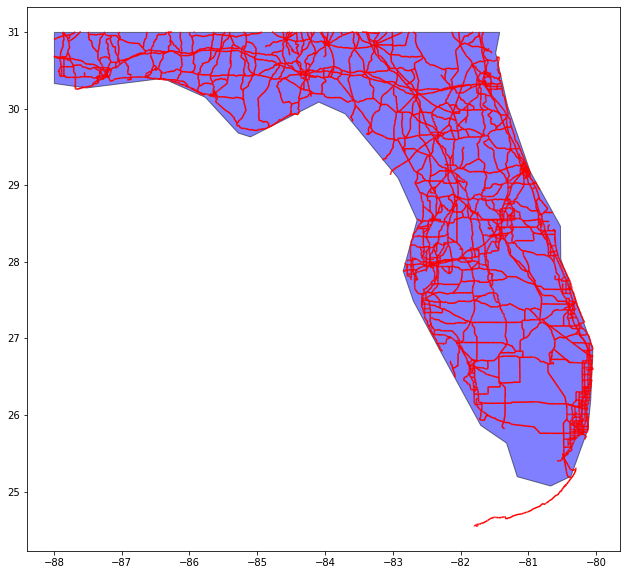

In [3]:
florida_polygon = Polygon([(-88, 24), (-88, 31), (-79, 31), (-79, 24)])

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
n_america = world[world["name"] == "United States of America"]

fig, ax = plt.subplots(figsize=(17,10))

florida_map = gpd.clip(n_america, florida_polygon)
florida_map.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)

edges = gpd.clip(edges, florida_polygon)
edges.plot(ax=ax, color="red")

In [10]:
florida_roads['maxspeed'] = '70 mph'
def add_edge_time(df):
    df['maxspeed_kmh'] = df['maxspeed'].str.extract('(\d+)').astype(int) * 1.609344
    df['duration'] = df['KM'] / df['maxspeed_kmh']

florida_roads['key'] = 0
add_edge_time(florida_roads)
florida_roads.head(2)

,OBJECTID,YEAR_RECOR,ROUTE_ID,BEGIN_POIN,END_POINT,F_SYSTEM,FACILITY_T,URBAN_CODE,RECTYPE,VERSION,RECID,ORIGID,CTFIPS,SOURCE,LGURB,SMURB,SIGN1,SIGNT1,SIGNN1,SIGNQ1,SIGN2,SIGNT2,SIGNN2,SIGNQ2,SIGN3,SIGNT3,SIGNN3,SIGNQ3,LNAME,MILES,KM,FCLASS,RUCODE,STATUS,NHS,STRAHNET,FAC_ID,CONN_ID,CONN_DES,CONN_MILES,LRSKEY,LRSSEQ,BEGMP,ENDMP,STFIPS,ShapeSTLen,geometry,maxspeed,key,maxspeed_kmh,duration
59667,59668,2010,48110000,0.388,0.865,3,2,68482,L,2014.05,12016553,12016553,33,H,125,68482,U98,U,98,None,S30,S,30,None,S298,S,298,None,None,0.436,0.702,2,3,1,0,0,None,None,None,0.0,004811000000033,1,0.388,3.972,12,826.453132,"LINESTRING (-87.43072 30.40485, -87.42579 30.4...",70 mph,0,112.65408,0.006231
79828,79829,2010,38090000,4.507,22.737,3,2,99999,L,2014.05,12016554,12016554,123,H,0,0,U98,U,98,None,S30,S,30,None,None,None,None,None,None,17.730,28.533,2,1,1,0,0,None,None,None,0.0,003809000000123,1,0.000,23.706,12,33924.900394,"LINESTRING (-83.90058 30.14111, -83.90050 30.1...",70 mph,0,112.65408,0.253280


When taking the entire USA, the `STFIPS` can be used to map the max highway speed

In [11]:
def add_incident_nodes(df_in): 
    df = df_in.copy()
    u_values = [str((round(i.geometry.coords[:][0][0],4),round(i.geometry.coords[:][0][1],4))) for i in df.itertuples()]
    v_values = [str((round(i.geometry.coords[:][-1][0],4),round(i.geometry.coords[:][-1][1],4))) for i in df.itertuples()]
    
    df['u'] = u_values
    df['v'] = v_values
    
    df.drop('geometry',inplace = True, axis=1)
    
    return df

florida_roads_formatted = add_incident_nodes(florida_roads)

In [12]:
florida_roads_formatted.head()

,OBJECTID,YEAR_RECOR,ROUTE_ID,BEGIN_POIN,END_POINT,F_SYSTEM,FACILITY_T,URBAN_CODE,RECTYPE,VERSION,RECID,ORIGID,CTFIPS,SOURCE,LGURB,SMURB,SIGN1,SIGNT1,SIGNN1,SIGNQ1,SIGN2,SIGNT2,SIGNN2,SIGNQ2,SIGN3,SIGNT3,SIGNN3,SIGNQ3,LNAME,MILES,KM,FCLASS,RUCODE,STATUS,NHS,STRAHNET,FAC_ID,CONN_ID,CONN_DES,CONN_MILES,LRSKEY,LRSSEQ,BEGMP,ENDMP,STFIPS,ShapeSTLen,maxspeed,key,maxspeed_kmh,duration,u,v
59667,59668,2010,48110000,0.388,0.865,3,2,68482,L,2014.05,12016553,12016553,33,H,125,68482,U98,U,98,None,S30,S,30,None,S298,S,298,None,None,0.436,0.702,2,3,1,0,0,None,None,None,0.0,004811000000033,1,0.388,3.972,12,826.453132,70 mph,0,112.65408,0.006231,"(-87.4307, 30.4048)","(-87.4245, 30.4013)"
79828,79829,2010,38090000,4.507,22.737,3,2,99999,L,2014.05,12016554,12016554,123,H,0,0,U98,U,98,None,S30,S,30,None,None,None,None,None,None,17.730,28.533,2,1,1,0,0,None,None,None,0.0,003809000000123,1,0.000,23.706,12,33924.900394,70 mph,0,112.65408,0.253280,"(-83.9006, 30.1411)","(-83.6193, 30.1005)"
79829,79830,2010,54020000,10.017,16.373,3,2,99999,L,2014.05,12002476,1200004384,65,H,0,0,U19,U,19,None,U27,U,27,None,S20,S,20,None,None,6.145,9.889,2,1,1,7,0,None,None,None,0.0,005402000000065,4,10.029,16.421,12,11789.572673,70 mph,0,112.65408,0.087782,"(-83.9113, 30.411)","(-83.8139, 30.3781)"
79830,79831,2010,54001000,9.295,9.635,1,2,99999,L,2014.05,12003413,1200004816,65,H,0,0,I10,I,10,None,S8,S,8,None,None,None,None,None,None,0.327,0.526,1,1,1,1,6,None,None,None,0.0,005400100000065,7,9.271,9.606,12,633.596299,70 mph,0,112.65408,0.004669,"(-83.8897, 30.4754)","(-83.8842, 30.4744)"
79831,79832,2010,54070000,10.135,14.614,4,2,99999,L,2014.05,12016555,12016555,65,H,0,0,C259,C,259,None,None,None,None,None,None,None,None,None,None,4.386,7.058,6,1,1,0,0,None,None,None,0.0,005450700000065,2,10.027,14.614,12,8171.548732,70 mph,0,112.65408,0.062652,"(-83.9208, 30.4784)","(-83.8733, 30.522)"


In [13]:
florida_roads_formatted['length'] = florida_roads_formatted['KM']*1000
florida_roads_formatted['CO2_eq_kg'] = pd.eval('florida_roads_formatted.length /1000 * 0.080513')

In [14]:
import re
def gen_nodes_gdfs(df):
    nodes_df = gpd.GeoDataFrame(columns=['nodes_pos','tag','x','y','osmid','geometry'],crs="EPSG:4326")
    
    nodes_df['nodes_pos'] = pd.unique(df[['u', 'v']].values.ravel('K'))
    
    pattern = re.compile(r'(\d+.\d+)')
    
    coords = nodes_df['nodes_pos'].str.extractall(pattern).unstack(level=-1)
    coords.columns = coords.columns.droplevel()
    coords.rename(columns = {0:'x',1:'y'},inplace=True)
    nodes_df['x'] = -coords.x.astype(float)
    nodes_df['y'] = coords.y.astype(float)
    nodes_df['osmid'] = nodes_df.nodes_pos
    nodes_df['geometry'] = [Point(x,y) for x,y in zip(nodes_df.x,nodes_df.y)]
    
    nodes_df['tag'] = 'road'
    nodes_df['new_idx'] = range(1000000000,1000000000 + len(nodes_df))
    nodes_df.set_index('new_idx', drop=True, inplace=True)
    
    return nodes_df

In [15]:
nodes_gdfs = gen_nodes_gdfs(florida_roads_formatted)
nodes_gdfs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15178 entries, 1000000000 to 1000015177
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   nodes_pos  15178 non-null  object  
 1   tag        15178 non-null  object  
 2   x          15178 non-null  float64 
 3   y          15178 non-null  float64 
 4   osmid      15178 non-null  object  
 5   geometry   15178 non-null  geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 830.0+ KB


In [16]:
nodes_map = pd.Series(data=nodes_gdfs.index, index=nodes_gdfs['osmid'])

In [17]:
G = ox.graph_from_gdfs(nodes_gdfs, florida_roads_formatted)

nx.relabel_nodes(G, dict(nodes_map), copy=False)
nx.set_node_attributes(G, nodes_gdfs.to_dict('index'), name=None)

In [18]:
G_s = ox.simplify_graph(G)

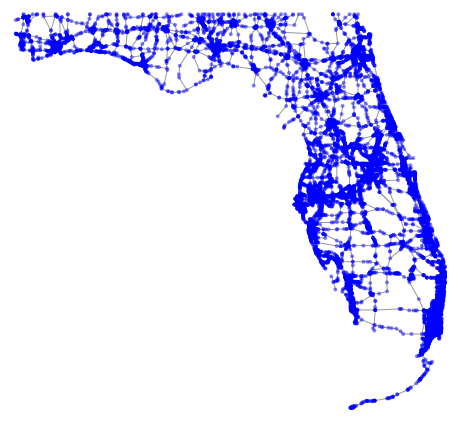

In [19]:
fig, ax = ox.plot_graph(G,node_color='blue',bgcolor='white',node_alpha=0.5)

Text(0.5, 1.0, 'connected components size')

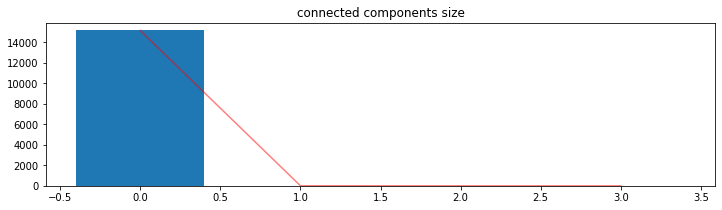

In [20]:
G_undirected = G.to_undirected()
G_undirected_s = G_s.to_undirected()

component_size = sorted([len(component) for component in nx.connected_components(G_undirected)], reverse=True)
fig, ax = plt.subplots(figsize=(12,3))
plt.bar(range(len(component_size)),component_size)
plt.plot(range(len(component_size)),component_size,color='red',alpha=0.5)
plt.title('connected components size')

In [21]:
largest_cc_nodes = max(nx.connected_components(G_undirected), key=len)
largest_cc = G_undirected.subgraph(largest_cc_nodes).copy()

largest_cc_nodes_s = max(nx.connected_components(G_undirected_s), key=len)
largest_cc_s = G_undirected_s.subgraph(largest_cc_nodes_s).copy()

It should be noted that by simplifying the graph, the edges attributes where added as list elements. 
For the duration attribute, theses element will have to be summed later on.

In [22]:
nx.write_gpickle(largest_cc_s,'data/BTS_florida_G.plk')